# Bubble Tea in California

I am a California native and a fan of bubble tea. As such, I thought it would be interesting to see what I can find about bubble tea shops in California.

I acquired bubble tea business information using the YelpAPI and ingested the data into a PostgreSQL database. I downloaded a zip_code_database.csv file from the following site,

    https://www.unitedstateszipcodes.org/zip-code-database/

which was imported into the database and used to provide a mapping of zip codes to county. Additionally, I downloaded and imported this file into the database,

    https://www2.census.gov/geo/docs/reference/codes/files/st06_ca_cou.txt

which provided a mapping from county to the corresponding FIPS county code. 

I ultimately ended up with two datasets:

    bubble_tea.csv - location information and rating/review counts of bubble tea businesses 
    hours.csv - bubble tea shop hour information
    
The two datasets are used in the analysis below.

In [1]:
%matplotlib inline

In [2]:
# Import packages
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from bokeh.io import show, output_notebook, save, output_file
from bokeh.models import ColumnDataSource, GMapOptions, HoverTool
from bokeh.plotting import gmap
from bokeh.core.enums import MapType

from settings import DATABASE

sns.set_style('white')

output_notebook()

Loading BokehJS ...

In [3]:
DEFAULT_FIGSIZE = (12,7)
def make_bar_plot(data, x=None, y=None, xlabel=None, ylabel=None, 
                  title=None, figsize=DEFAULT_FIGSIZE, display_values=True):
    """
    Reusable code to create bar plots
    """
    plt.subplots(figsize=figsize)
    if isinstance(data, pd.core.series.Series):
        x = data
        y = data.index
        ax = sns.barplot(y=y, x=x)
    if isinstance(data, pd.core.frame.DataFrame):
        x = data[x]
        y = data[y]
        ax = sns.barplot(x=x, y=y)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if display_values:
        for i, v in enumerate(x):
            ax.text(v + 1, i + 0.15, str(v), fontweight='bold')
    sns.despine()
    return ax, plt

In [4]:
def make_geoscatter_plot(lat, lon, title, output_file_name=None, 
                         map_options=None, point_options=None, hover_options=None):
    """
    Reusable code to create geo-scatter plots
    """
    data = {
        'lat': list(lat),
        'lon': list(lon)
    }
    
    if map_options is None:
        map_options = {
            'lat': 37.0000,
            'lng': -120.0000,
            'map_type': MapType.roadmap,
            'zoom': 6
        }
        
    if point_options is None:
        point_options = {
            'x': 'lon',
            'y': 'lat',
            'size': 4,
            'fill_color': 'blue',
            'fill_alpha': 0.75
        }
        
    
        
    map_options = GMapOptions(**map_options)
    
    p = gmap(os.environ['GOOGLE_MAPS_API_KEY'], map_options, title=title)
    
    if hover_options is not None:
        tooltips = []
        for k, v in hover_options.items():
            tooltips.append((v['description'], '@{}'.format(k)))
            data[k] = list(v['data'])
        hover = HoverTool(tooltips=tooltips)
        p.add_tools(hover)
        
    source = ColumnDataSource(data=data)
    
    p.circle(source=source, **point_options)
    return p
    

In [5]:
# Create and process DataFrame
df_kwargs = {
    'index_col': False,
    'encoding': 'utf-8',
    'dtype': {
        'phone': str,
        'fips': str,
        'zip_code': str
    }
}
bubble_tea_df = pd.read_csv('./csvs/bubble_tea.csv', **df_kwargs)
bubble_tea_df['full_address'] = bubble_tea_df['address1'] + ', ' + \
bubble_tea_df['city'] +  ', ' + bubble_tea_df['state'] + ' ' + bubble_tea_df['zip_code']
bubble_tea_df.fillna(value='', inplace=True)

In [5]:
bubble_tea_df.head()

,id,name,country,address1,address2,address3,city,state,zip_code,county,fips,phone,latitude,longitude,rating,review_count,full_address
0,8auO8j1mw06aHR1KPYYiiw,Hot Spot,US,2321 Santa Clara Ave,,,Alameda,CA,94501,Alameda County,06001,+15102394602,37.765703,-122.242379,3.5,191,"2321 Santa Clara Ave, Alameda, CA 94501"
1,00f_QqY53x-JWoJSBoFc4w,i-Tea,US,1626 Park St,,,Alameda,CA,94501,Alameda County,06001,+15102638789,37.767355,-122.240030,3.5,188,"1626 Park St, Alameda, CA 94501"
2,zXITBTAroCWThpcr58LQGQ,Panda Express,US,2630 Fifth St,Ste 40,,Alameda,CA,94501,Alameda County,06001,+15107481288,37.786482,-122.281385,2.5,73,"2630 Fifth St, Alameda, CA 94501"
3,mxdHEovuY2-opvpH1Ui2wA,Sharetea,US,2670 5th St,,,Alameda,CA,94501,Alameda County,06001,+15102275523,37.786722,-122.281345,3.5,135,"2670 5th St, Alameda, CA 94501"
4,GeYbur3yjPw4QIfWMbQHfQ,Sip of the World,US,,,,Alameda,CA,,,,+15107478495,37.763607,-122.258202,4.5,3,


In [6]:
count_by_city = bubble_tea_df.groupby('city').size()

In [7]:
count_by_city.nlargest(5)

city
San Francisco    84
San Jose         76
Los Angeles      73
San Diego        35
Fremont          26
dtype: int64

In [8]:
count_by_city = bubble_tea_df['city'].value_counts().nlargest(20)

In [9]:
counties = bubble_tea_df[bubble_tea_df['city'].isin(count_by_city.index)]['county'].unique()
counties

array(['Los Angeles County', 'Alameda County', 'Santa Clara County',
       'Orange County', '', 'Sacramento County', 'San Diego County',
       'San Francisco County'], dtype=object)

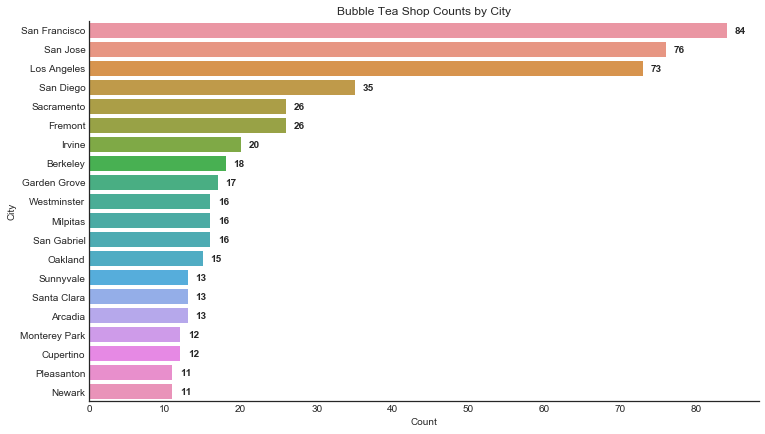

In [10]:
ax, plt = make_bar_plot(
    data=count_by_city,
    xlabel='Count',
    ylabel='City',
    title='Bubble Tea Shop Counts by City'
)
plt.savefig('./png/shop_count_by_city.png')

Top 20 cities in California with the most bubble tea shops. It's interesting to note that most of the top 20 cities are located in the following counties
* Alameda County
* Los Angeles County
* Orange County
* Sacramento County
* San Diego County
* San Francisco County
* San Mateo County
* Santa Clara County

Based on these counties, it seems that bubble tea locations are concentrated mostly in the [Bay Area](https://dothebay.com/p/bays-best-boba) and parts of Southern California (most notably Los Angeles / Orange County Area). Overall, there seems to be a large [bubble tea culture](http://www.laweekly.com/restaurants/how-boba-became-an-integral-part-of-asian-american-culture-in-los-angeles-7819797) in these regions.

In [11]:
hover_options = {
    'full_address': {
        'data': bubble_tea_df['full_address'], 
        'description': 'Address'
    },
    'name': {
        'data': bubble_tea_df['name'],
        'description': 'Name'
    }
}

p = make_geoscatter_plot(
    lat=bubble_tea_df['latitude'],
    lon=bubble_tea_df['longitude'],
    title='Bubble Tea Shops in Califonia',
    hover_options=hover_options
)
save(p, './html/bubble_tea_ca.html')
show(p)

C:\Users\huynh\Anaconda3\lib\site-packages\bokeh\io\saving.py:123: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
C:\Users\huynh\Anaconda3\lib\site-packages\bokeh\io\saving.py:136: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


The plot above shows a map of bubble tea locations in California. The plot really helps to show that most of the bubble tea locations are clustered in the Bay Area and Southern California.

In [13]:
point_options = {
    'x': 'lon',
    'y': 'lat',
    'size': 4,
    'fill_color': 'blue',
    'fill_alpha': 0.75
}

bay_area_map_options = {
    'lat': 37.5,
    'lng': 	-122.1,
    'map_type': MapType.roadmap,
    'zoom': 9
}

p_ba = make_geoscatter_plot(
    lat=bubble_tea_df['latitude'],
    lon=bubble_tea_df['longitude'],
    title='Bubble Tea Shops in the Bay Area',
    map_options=bay_area_map_options,
    point_options=point_options,
    hover_options=hover_options
)
save(p_ba, './html/bubble_tea_bay_area.html')
show(p_ba)

los_angeles_map_options = {
    'lat': 34.052235,
    'lng': -118,
    'map_type': MapType.roadmap,
    'zoom': 9
}

p_la =  make_geoscatter_plot(
    lat=bubble_tea_df['latitude'],
    lon=bubble_tea_df['longitude'],
    title='Bubble Tea Shops in the Greater Los Angeles Area',
    map_options=los_angeles_map_options,
    point_options=point_options,
    hover_options=hover_options
)
save(p_la, './html/bubble_tea_greater_la.html')
show(p_la)

C:\Users\huynh\Anaconda3\lib\site-packages\bokeh\io\saving.py:123: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
C:\Users\huynh\Anaconda3\lib\site-packages\bokeh\io\saving.py:136: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


The two interactive plots above are zoomed in to the Bay Area and Greater Los Angeles Areas to show in greater detail the spread of bubble tea locations in these two areas. Hovering over data points shows the address and names of the bubble tea locations.

In [14]:
count_by_shop_name = bubble_tea_df['name'].value_counts().nlargest(10)
count_by_shop_name

Quickly            56
Sharetea           32
BAMBU              22
Gong Cha           21
T4                 21
i-Tea              17
Lollicup           16
Tapioca Express    13
Happy Lemon        13
It's Boba Time     10
Name: name, dtype: int64

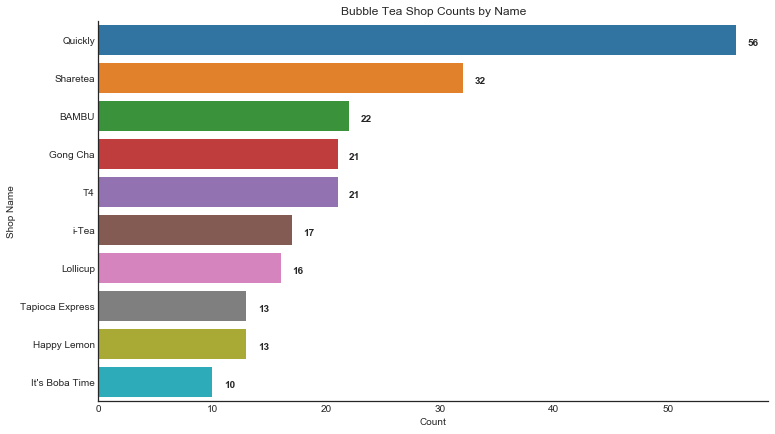

In [15]:
ax, plt = make_bar_plot(
    data=count_by_shop_name,
    xlabel='Count',
    ylabel='Shop Name',
    title='Bubble Tea Shop Counts by Name'
)
plt.savefig('./png/shop_count_by_name.png')

Top 10 most frequent bubble tea shops in California. Not a big surprise that Quickly is at the very top, since it is [one of the largest milk tea franchises](https://en.wikipedia.org/wiki/Quickly) in the world. [Taiwanese chains have been racing over to California](https://www.forbes.com/sites/rosatrieu/2014/01/01/three-taiwanese-bubble-tea-chains-racing-for-california/#2de2751927a8), so it makes sense to see Sharetea, Gong Cha, T4, and i-Tea among the top 10. Chains such as Lollicup and Tapioca Express were founded in Southern California, so it makes sense that they have several locations as well.


In [16]:
highest_review_count = bubble_tea_df[
    ['name', 'review_count', 'address1', 'city', 
     'state', 'zip_code', 'county', 'latitude', 'longitude']
].sort_values('review_count', ascending=False)

top_10 = highest_review_count.head(10)
top_10

,name,review_count,address1,city,state,zip_code,county,latitude,longitude
552,Half & Half Tea Express - Monterey Park,2529,141 N Atlantic Blvd,Monterey Park,CA,91754,Los Angeles County,34.063557,-118.134434
844,Purple Kow,2203,3620 Balboa St,San Francisco,CA,94121,San Francisco County,37.775906,-122.497818
890,Half & Half Tea House,1869,120 N San Gabriel Blvd,San Gabriel,CA,91778,Los Angeles County,34.104627,-118.090156
842,Plentea - San Francisco,1728,341 Kearny St,San Francisco,CA,94108,San Francisco County,37.791426,-122.404249
474,Pine & Crane,1694,1521 Griffith Park Blvd,Los Angeles,CA,90026,Los Angeles County,34.090596,-118.277172
1190,Zero Degrees,1616,9822 Bolsa Ave,Westminster,CA,92683,Orange County,33.744169,-117.957217
888,Factory Tea Bar,1595,323 S Mission Dr,San Gabriel,CA,91776,Los Angeles County,34.097560,-118.109170
933,Pekoe,1588,3276 S White Rd,San Jose,CA,95148,Santa Clara County,37.314558,-121.790189
358,Cha For Tea,1553,4187 Campus Dr,Irvine,CA,92612,Orange County,33.650665,-117.838943
360,Class 302,1539,18090 Culver Dr,Irvine,CA,92612,Orange County,33.663662,-117.825892


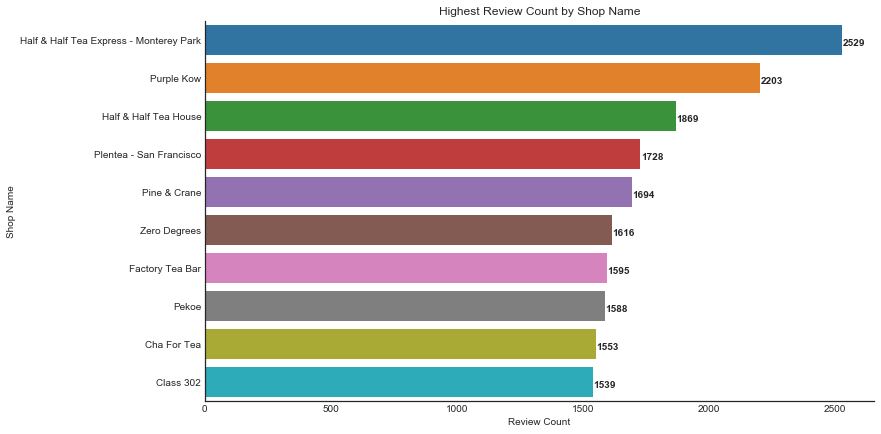

In [18]:
ax, plt = make_bar_plot(
    top_10,
    x='review_count',
    y='name',
    xlabel='Review Count',
    ylabel='Shop Name',
    title='Highest Review Count by Shop Name'
)
plt.savefig('./png/review_count_by_shop.png')

Top 10 most rated bubble tea shops in California. 

In [19]:
count_by_rating = bubble_tea_df['rating'].value_counts().reset_index().rename(
    columns={'index': 'rating', 'rating': 'count'}
).sort_values(by='rating')
count_by_rating

,rating,count
6,0.0,19
9,1.0,1
8,1.5,3
7,2.0,13
5,2.5,33
3,3.0,93
1,3.5,297
0,4.0,448
2,4.5,255
4,5.0,40


Let's try to see what some of those lower ratings are (0.0, 1.0).

In [20]:
bubble_tea_df[['name', 'full_address', 'rating', 'review_count']].query('rating == 0.0')

,name,full_address,rating,review_count
81,K-Food Korean Grill,"3438 Wilshire Blvd, Beverly Hills, CA 90212",0.0,0
119,"Brew & Steep, LLC","4110 Edison Ave, Chino, CA 91710",0.0,0
120,Bubble Tea & Coffee,"11756 Central Ave, Chino, CA 91710",0.0,0
133,Gong Cha,"17883 Colima Rd, City of Industry, CA 91748",0.0,0
164,HOLD FOR TEA,"6000 Sepulveda Blvd, Culver City, CA 90230",0.0,0
176,Zen Tea,"19620 Stevens Creek Blvd, Cupertino, CA 95014",0.0,0
191,Teaspoon,"110 F St, Davis, CA 95616",0.0,0
214,Krazy Boba,"10911 Garvey Ave, El Monte, CA 91733",0.0,0
256,Boba Creamery,"39055 Hastings St, Fremont, CA 94538",0.0,0
257,Boba Palace,"3880 Decoto Rd, Fremont, CA 94536",0.0,0


Shops with 0.0 ratings simply don't have any reviews yet.

In [21]:
bubble_tea_df[['name', 'full_address', 'rating', 'review_count']].query('rating == 1.0').head()

,name,full_address,rating,review_count
53,TrueCeylonTea,"5441 Aldrin Ct, Bakersfield, CA 93313",1.0,1


According to Yelp, TrueCeylonTea is not actually a bubble tea shop, but a tea manufacturer - https://www.yelp.com/biz/trueceylontea-bakersfield

With that in mind, let's remove the first two rows of the count_by_rating DataFrame

In [22]:
count_by_rating = count_by_rating.query('rating > 1')
count_by_rating['product'] = count_by_rating['rating'] * count_by_rating['count']
count_by_rating

C:\Users\huynh\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,rating,count,product
8,1.5,3,4.5
7,2.0,13,26.0
5,2.5,33,82.5
3,3.0,93,279.0
1,3.5,297,1039.5
0,4.0,448,1792.0
2,4.5,255,1147.5
4,5.0,40,200.0


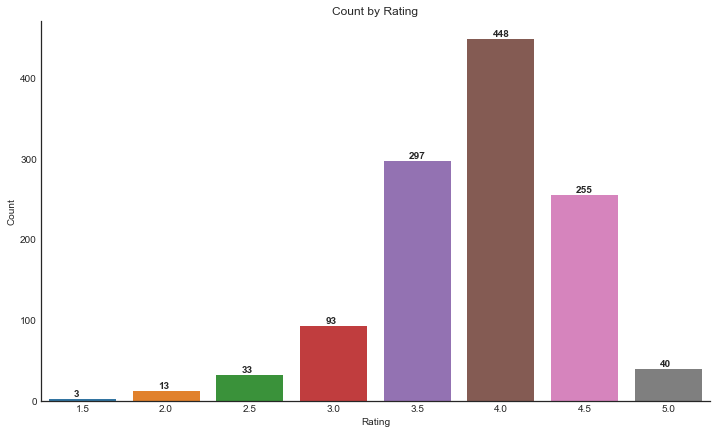

In [24]:
ax, plt = make_bar_plot(
    count_by_rating,
    x='rating',
    y='count',
    xlabel='Rating',
    ylabel='Count',
    title='Count by Rating',
    display_values=False
)
for i, v in enumerate(count_by_rating['count']):
    ax.text(i - 0.1, v + 3, str(v), fontweight='bold')
plt.savefig('./png/count_by_rating.png')

In [25]:
avg = count_by_rating['product'].sum() / count_by_rating['count'].sum()
avg

3.8671742808798646

The bar plot seems left skewed, with an average rating of 3.87 and a mode of 4, which is consistent with what we normally see in a left skewed distribution plot.

In [27]:
num_to_days = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

hours_df = pd.read_csv('./csvs/hours.csv')
hours_df['day_str'] = hours_df['day'].apply(lambda x: num_to_days.get(x))
hours_df.head()

,bubble_tea_id,day,start,end,is_overnight,day_str
0,ohosmz6FXVAeoW5nUkYwng,0,1200,2200,False,Monday
1,ohosmz6FXVAeoW5nUkYwng,2,1200,2200,False,Wednesday
2,ohosmz6FXVAeoW5nUkYwng,3,1200,2200,False,Thursday
3,ohosmz6FXVAeoW5nUkYwng,4,1200,2200,False,Friday
4,ohosmz6FXVAeoW5nUkYwng,5,1200,2200,False,Saturday


In [28]:
overnight_df = hours_df[hours_df['is_overnight']]
overnight_df.head()

,bubble_tea_id,day,start,end,is_overnight,day_str
55,kXrHt3XkNd_q5rISuvuvVg,4,1100,230,True,Friday
56,kXrHt3XkNd_q5rISuvuvVg,5,1130,230,True,Saturday
164,QUK6uKjFBN1HWCpxwC0oMg,0,1300,100,True,Monday
168,QUK6uKjFBN1HWCpxwC0oMg,1,1300,100,True,Tuesday
182,QUK6uKjFBN1HWCpxwC0oMg,2,1300,100,True,Wednesday


In [29]:
# Join overnight_df to bubble_tea_df
merged_df = bubble_tea_df.merge(overnight_df, left_on='id', right_on='bubble_tea_id', how='inner')
merged_df.head()

,id,name,country,address1,address2,address3,city,state,zip_code,county,...,longitude,rating,review_count,full_address,bubble_tea_id,day,start,end,is_overnight,day_str
0,B4PzF0KegTWvKGJ2g3g9zw,Lollicup,US,228 West Valley Blvd.,Ste 106A,,Alhambra,CA,91801,Los Angeles County,...,-118.124910,3.5,262,"228 West Valley Blvd., Alhambra, CA 91801",B4PzF0KegTWvKGJ2g3g9zw,4,1100,100,True,Friday
1,B4PzF0KegTWvKGJ2g3g9zw,Lollicup,US,228 West Valley Blvd.,Ste 106A,,Alhambra,CA,91801,Los Angeles County,...,-118.124910,3.5,262,"228 West Valley Blvd., Alhambra, CA 91801",B4PzF0KegTWvKGJ2g3g9zw,5,1100,100,True,Saturday
2,RBTs8e2GHgfUhraghoUqKw,Tea Station,US,560 W Main St,Ste A,,Alhambra,CA,91804,Los Angeles County,...,-118.132582,3.0,536,"560 W Main St, Alhambra, CA 91804",RBTs8e2GHgfUhraghoUqKw,4,1130,100,True,Friday
3,RBTs8e2GHgfUhraghoUqKw,Tea Station,US,560 W Main St,Ste A,,Alhambra,CA,91804,Los Angeles County,...,-118.132582,3.0,536,"560 W Main St, Alhambra, CA 91804",RBTs8e2GHgfUhraghoUqKw,5,1130,100,True,Saturday
4,9HmrlkVt9r6TP3emZ6gT3g,Guppy House,US,5642 E La Palma Ave,Ste 107,,Anaheim,CA,92807,Orange County,...,-117.791181,3.0,678,"5642 E La Palma Ave, Anaheim, CA 92807",9HmrlkVt9r6TP3emZ6gT3g,4,1100,100,True,Friday


In [30]:
# Find out which day is most popular for overnight
count_by_day = merged_df['day'].value_counts().reset_index().rename(
    columns={'index': 'day', 'day': 'count'}
).sort_values(by='day')
count_by_day['day_str'] = count_by_day['day'].apply(lambda x: num_to_days.get(x))
count_by_day

,day,count,day_str
6,0,20,Monday
5,1,20,Tuesday
3,2,22,Wednesday
2,3,28,Thursday
1,4,64,Friday
0,5,64,Saturday
4,6,20,Sunday


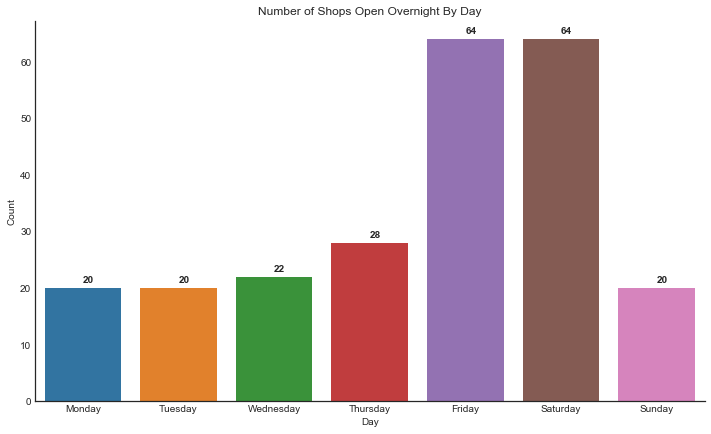

In [31]:
ax, plt = make_bar_plot(
    count_by_day,
    x='day_str',
    y='count',
    xlabel='Day',
    ylabel='Count',
    title='Number of Shops Open Overnight By Day',
    display_values=False
)
for i, v in enumerate(count_by_day['count']):
    ax.text(i, v + 1, str(v), fontweight='bold')
plt.savefig('./png/overnight_by_day.png')

Number of shops open overnight by day. The trend is that as the week goes on, more shops are open overnight, with most shops open overnight on Fridays and Saturdays. 

In [32]:
distinct_open_overnight_shop = merged_df[['id', 'name', 'full_address', 'latitude', 'longitude']].drop_duplicates()
distinct_open_overnight_shop.head()

,id,name,full_address,latitude,longitude
0,B4PzF0KegTWvKGJ2g3g9zw,Lollicup,"228 West Valley Blvd., Alhambra, CA 91801",34.078130,-118.124910
2,RBTs8e2GHgfUhraghoUqKw,Tea Station,"560 W Main St, Alhambra, CA 91804",34.092268,-118.132582
4,9HmrlkVt9r6TP3emZ6gT3g,Guppy House,"5642 E La Palma Ave, Anaheim, CA 92807",33.858527,-117.791181
6,QZF2utYIsm85e9x2TS0e4w,Boba Ave Express,"1437 S Baldwin Ave, Arcadia, CA 91007",34.122711,-118.055450
8,Uh8LPCRstLnJ-ZY3B41N9w,Nest Tea House,"556 Las Tunas Dr, Arcadia, CA 91007",34.107021,-118.050728


In [34]:
hover_options = {
    'full_address': {
        'data': distinct_open_overnight_shop['full_address'], 
        'description': 'Address'
    },
    'name': {
        'data': distinct_open_overnight_shop['name'],
        'description': 'Name'
    }
}

p = make_geoscatter_plot(
    lat=distinct_open_overnight_shop['latitude'],
    lon=distinct_open_overnight_shop['longitude'],
    title='Bubble Tea Shops Open Past Midnight',
    hover_options=hover_options
)
save(p, './html/overnight.html')
show(p)

C:\Users\huynh\Anaconda3\lib\site-packages\bokeh\io\saving.py:123: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
C:\Users\huynh\Anaconda3\lib\site-packages\bokeh\io\saving.py:136: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


Interactive plot of bubble tea shops open overnight (to satisfy those late night bubble tea cravings).